In [ ]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

## Setup
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Fetch data from Google Drive 
# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
#url = 'https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)


Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:20<00:00, 70.3MB/s]


In [ ]:
filenames_list = []
dataset_dir = f'{data_root}/img_align_celeba/img_align_celeba/'

for filename in sorted(os.listdir(dataset_dir)):
    filenames_list.append(dataset_dir + filename)

filenames_list = filenames_list[:100000]
print(len(filenames_list))

100000


In [ ]:
filenames_list[0]

'data/celeba/img_align_celeba/img_align_celeba/000001.jpg'

In [ ]:
#Colourization class
import numpy as np
from tensorflow.keras.utils import Sequence

from skimage import io, color
from skimage.transform import resize
from matplotlib import pyplot as plt

img_size = 128

class Generator(Sequence):

    def __init__(self, filenames_list, batch_size, img_size):
        self.filenames_list = filenames_list
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.filenames_list) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_x = self.filenames_list[idx * self.batch_size:(idx + 1) * self.batch_size]

        input_tensor = np.empty((self.batch_size, self.img_size, self.img_size, 1), dtype=np.float32)
        output_tensor = np.empty((self.batch_size, self.img_size, self.img_size, 2), dtype=np.float32)

        i = 0
        for filename in batch_x:

            read_image = io.imread(filename)

            image = resize(read_image, (self.img_size, self.img_size), anti_aliasing=False, mode='constant')


            if image.shape == (self.img_size, self.img_size, 3) :
               try:
                    if not ((image[:, :, 0] == image[:, :, 1]).all()) \
                            or not ((image[:, :, 1] == image[:, :, 2]).all()):  # if not a BW image

                        image = color.rgb2lab(image)
                        # array image for output tensor
                        output_tensor[i, :] = (image[:, :, 1:] / 128)
                        # array values for input tensor
                        input_tensor[i, :] = (image[:, :, 0] / 100).reshape(img_size, img_size, 1)
                        i += 1
               except:
                    print(image.shape)
                    io.imshow(image)
                    plt.show()

        return input_tensor, output_tensor

In [ ]:
import os
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Input, ZeroPadding2D, Concatenate, AveragePooling2D, UpSampling2D
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Root directory for the logs
log_root = f'{data_root}/logs'
# Path to folder with the dataset
weights_root = f'{data_root}//weights'

# Create required directories 
if not os.path.exists(log_root):
  os.makedirs(log_root)
  os.makedirs(weights_root)

In [ ]:
img_size = 128
batch_size = 64

training_batch_generator = Generator(filenames_list=filenames_list, batch_size=batch_size, img_size=img_size)

tensorboard = TensorBoard(log_dir=log_root+"/{}".format(time()))

# model

input_layer = Input(shape=(img_size, img_size, 1))

hidden_layer_1 = Conv2D(32, (7, 7), activation='relu', padding='same')(input_layer)
hidden_layer_1 = BatchNormalization()(hidden_layer_1)
hidden_layer_1 = AveragePooling2D()(hidden_layer_1)
hidden_layer_2 = Conv2D(64, (5, 5), activation='relu',  padding='same')(hidden_layer_1)
hidden_layer_2 = BatchNormalization()(hidden_layer_2)
hidden_layer_2 = AveragePooling2D()(hidden_layer_2)
hidden_layer_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(hidden_layer_2)
hidden_layer_3 = BatchNormalization()(hidden_layer_3)
hidden_layer_3 = UpSampling2D()(hidden_layer_3)
hidden_layer_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(hidden_layer_3)
hidden_layer_4 = BatchNormalization()(hidden_layer_4)
hidden_layer_4 = UpSampling2D()(hidden_layer_4)
hidden_layer_5 = Conv2D(32, (3, 3), activation='relu', padding='same')(hidden_layer_4)
hidden_layer_5 = BatchNormalization()(hidden_layer_5)

output_layer = Conv2D(2, (3, 3), activation='tanh', padding='same')(hidden_layer_5)

model = Model(inputs=input_layer, outputs=output_layer)

opt = tensorflow.keras.optimizers.RMSprop()

model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

#plot_model(model, to_file='logs/rcnn/rcnn_model.png')
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      1600      
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 64, 64, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 64)       256 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
1563/1563 [==============================] - 1036s 652ms/step - loss: 0.0122 - accuracy: 0.6020
Epoch 2/10
1563/1563 [==============================] - 1034s 658ms/step - loss: 0.0078 - accuracy: 0.6242
Epoch 3/10
1563/1563 [==============================] - 1037s 660ms/step - loss: 0.0076 - accuracy: 0.6277
Epoch 4/10
1563/1563 [==============================] - 1049s 667ms/step - loss: 0.0074 - accuracy: 0.6301
Epoch 5/10
1563/1563 [==============================] - 1050s 668ms/step - loss: 0.0074 - accuracy: 0.6286
Epoch 6/10
1563/1563 [==============================] - 1054s 671ms/step - loss: 0.0072 - accuracy: 0.6334
Epoch 7/10
1563/1563 [==============================] - 1033s 657ms/step - loss: 0.0072 - accuracy: 0.6353
Epoch 8/10
1563/1563 [==============================] - 1015s 646ms/step - loss: 0.0072 - accuracy: 0.6357
Epoch 9/10
1563/1563 [==============================] - 1019s 649ms/step - loss: 0.0071 - accuracy: 0.6367
Epoch 10/10
1563/1563 [==============

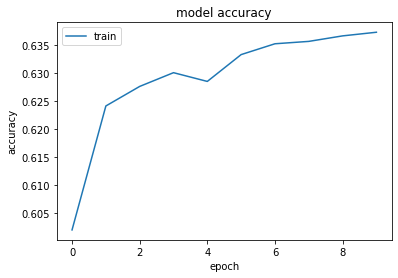

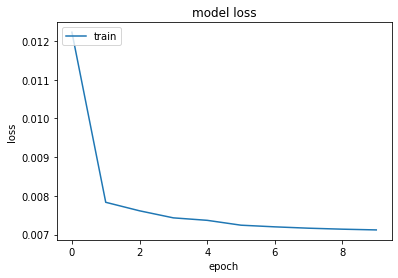

In [ ]:
with tf.device("/gpu:0"):
   history = model.fit_generator(training_batch_generator, epochs=10, verbose=1, use_multiprocessing=True,workers=8)
   #history = model.fit(training_batch_generator, epochs=10, verbose=1,workers=8)

   print(history.history.keys())
   # summarize history for accuracy
   plt.plot(history.history['accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.savefig(log_root+"/accuracy_plot.png")
   plt.show()
   # summarize history for loss
   plt.plot(history.history['loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.savefig(log_root+"/loss_plot.png")
   plt.show()

model.save(weights_root+"/AECNNs.h5")


In [ ]:
import numpy as np
import os
from keras.models import load_model
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize
import pandas as pd

In [ ]:
img_size = 128
dataset_dir = f'{data_root}/img_align_celeba/img_align_celeba/'


def ret_input_output_tensor(dataset_dir, n_images):
    input_tensor = np.empty((n_images, img_size, img_size, 1))
    output_tensor = np.empty((n_images, img_size, img_size, 2))

    i = 0
    print(len(os.listdir(dataset_dir)))
    for filename in reversed(sorted(os.listdir(dataset_dir))):

        if filename.endswith('.jpg'):

            image = io.imread(dataset_dir + filename)
            image = resize(image, (img_size, img_size, 3), anti_aliasing=False, mode='constant')
            image = color.rgb2lab(image)

            if image.shape == (img_size, img_size, 3):  # if not a BW image
                # array image for output tensor
                output_tensor[i, :] = (image[:, :, 1:] / 128)
                # array values for input tensor
                input_tensor[i, :] = (image[:, :, 0] / 100).reshape(img_size, img_size, 1)
                i += 1

        if i >= n_images: break

    return input_tensor, output_tensor


In [ ]:
print(os.listdir())
model = load_model("/content/data/AECNNs.h5")

# prediction

input_tensor, output_tensor = ret_input_output_tensor(dataset_dir, 10)

prediction = model.predict(input_tensor)

In [ ]:
for i in range(10):
    print("input tensor :\n", input_tensor[i].shape)
    print("prediction :\n", prediction[i])
    print("output tensor :\n", output_tensor[i])

    input_image = np.concatenate((input_tensor[i], np.zeros((img_size, img_size, 2))), axis=2)
    input_image[:, :, 0] = input_image[:, :, 0] * 100
    input_image = color.lab2rgb(input_image)
    print(input_image.shape)
    plt.imshow(input_image, cmap='gray')
    plt.show()
    plt.imsave('/content/data/log/'+str(i)+'_input.png', input_image)

    output_image = np.concatenate((input_tensor[i], prediction[i]), axis=2)
    output_image[:, :, 0] = output_image[:, :, 0] * 100
    output_image[:, :, 1:] = (output_image[:, :, 1:]) * 128
    output_image = color.lab2rgb(output_image)
    print(output_image.shape)

    plt.imshow(output_image)
    plt.show()
    plt.imsave('/content/data/log/' + str(i) + '_prediction.png', output_image)

    output_image = np.concatenate((input_tensor[i], output_tensor[i]), axis=2)
    output_image[:, :, 0] = output_image[:, :, 0] * 100
    output_image[:, :, 1:] = (output_image[:, :, 1:] ) * 128

    output_image = color.lab2rgb(output_image)
    plt.imshow(output_image)
    plt.show()
    plt.imsave('/content/data//log/' + str(i) + '_actual.png', output_image)

print(prediction.shape)
print(pd.DataFrame(data=output_tensor[0,:,:,0]).describe())
print(pd.DataFrame(data=prediction[0,:,:,0]).describe())
